##　ニューラルネットワーク

損失関数で求めた誤差を各パラメータに逆伝播して損失に対する勾配をもとめ、勾配に応じてパラメータを更新する

線形関数（各パラメータを含む）に活性化関数（非線形関数）を適用することで、複雑な関数として動く
o = tanh(wx + b)

oとｘはスカラーでもベクトルでも
ｗもスカラーでも行列でも
ｂはスカラーかベクトル（入力と出力の次元は同じ）

誤差関数の理解

線形モデルでは誤差関数が凸型だが、ニューラルネットでは各パラメータに唯一の解が無く、凸上にならない

活性化関数の意味

線形変換では10点々での評価でも11点を出すなど出力を特定の範囲に制限できない

1/(1+e** -x)を計算するnn.Sigmoidやtanhなどを用いることで解決できる
xが負の無限大に近づくと0または―1へ、正の無限大に近づくと１になる2

最適な活性化関数の選択

活性化関数なしでは繰り返し使用しても同じ形式の関数が得られる（アフィン変換）拡大回転等のみ
活性化関数は微分可能

活性化関数は入力に対して感度の高い領域を保有し、入力値の重要な変化に応じ変化も大きくなる。訓練に必要な特徴
また入力値の変化に出力が変化しないような飽和領域も保有している

## nnモジュール

In [72]:
%matplotlib inline
import numpy as np
import torch
import torch.optim as optim

t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) # <1>
t_u = torch.tensor(t_u).unsqueeze(1) # <1>

t_u.shape

torch.Size([11, 1])

In [73]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([ 9,  4,  2,  6,  5,  8,  0, 10,  1]), tensor([3, 7]))

In [74]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

In [75]:
import torch.nn as nn
linear_model = nn.Linear(1, 1)#コンストラクタに引数を与える
linear_model(t_un_val)

tensor([[8.0942],
        [2.1333]], grad_fn=<AddmmBackward0>)

In [76]:
#インスタンスと引数を渡すと、同じ引数をもつfowardが実行される
#下は同じだが、foward()は呼ばない

#y = model(x)
#y = model.foward(x)

nnで線形モデル作成（無駄だが）

In [77]:
import torch.nn as nn
#Linearの引数は三つ（入力特徴量の次元、出力特徴量の次元、バイアルの有無（デフォルトはTrue））
linear_model = nn.Linear(1, 1)
linear_model(t_un_val)

tensor([[-3.9860],
        [-1.5731]], grad_fn=<AddmmBackward0>)

In [78]:
linear_model.weight

Parameter containing:
tensor([[-0.4015]], requires_grad=True)

In [79]:
linear_model.bias

Parameter containing:
tensor([-0.6978], requires_grad=True)

In [80]:
#一部部省略して入力が可能、これはバッチ次元（０）を省略している
x = torch.ones(1)
linear_model(x)

tensor([-1.0993], grad_fn=<AddBackward0>)

In [81]:
# nn.Moduleとそのサブクラスは複数の入出力を同時に扱える
# 入力の０次元はバッチ数を想定
# バッチ数：１０、特量量の数：１

x = torch.ones(10, 1)
linear_model(x)

tensor([[-1.0993],
        [-1.0993],
        [-1.0993],
        [-1.0993],
        [-1.0993],
        [-1.0993],
        [-1.0993],
        [-1.0993],
        [-1.0993],
        [-1.0993]], grad_fn=<AddmmBackward0>)

バッチの最適化

バッチ処理をする理由はリソースの飽和を防ぐ、バッチ全体の統計情報使用しているモデルもありバッチサイズが大きくなると性能向上する

In [82]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) # 余分な次元の追加
t_u = torch.tensor(t_u).unsqueeze(1)

In [83]:
liner_model = nn.Linear(1, 1)
#optimaizerの引数はパラメータとlr
optimaizer = optim.SGD(
    linear_model.parameters(),#linear_modelのパラメータを
    lr = 1e-2)

In [84]:
linear_model.parameters()

<generator object Module.parameters at 0xffff4ee2fcf0>

In [85]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[-0.4015]], requires_grad=True),
 Parameter containing:
 tensor([-0.6978], requires_grad=True)]

In [86]:
#modelは引数にいれ使用
#損失関数もできものを使用
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val, t_c_train, t_c_val):
    for epoch in range(1, n_epochs +1):
        t_p_train = model(t_u_train)
        loss_train = loss_fn(t_p_train, t_c_train)
        
        t_p_val = model(t_u_val)
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward() # <2>
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")

In [102]:
#損失関数はnn.MSELossで既存のものを使用
#nn.はインスタンスを作成し関数として使用
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 74.8838, Validation loss 280.6159
Epoch 1000, Training loss 6.0577, Validation loss 22.2898
Epoch 2000, Training loss 3.6136, Validation loss 6.1221
Epoch 3000, Training loss 3.1096, Validation loss 3.4137

Parameter containing:
tensor([[5.1101]], requires_grad=True)
Parameter containing:
tensor([-16.2276], requires_grad=True)


## ニューラルネット構築

In [103]:
#nnモジュールの連結にnn.sequentialを使用
#13は適当入出力は合わせる

seq_model = nn.Sequential(
    nn.Linear(1, 13),
    nn.Tanh(),
    nn.Linear(13, 1))

seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [104]:
#parametersはoptimaizerが取得するパラメータ
#bavkfowrdで計算されるもの
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

In [105]:
#パラメータに名前があり識別できる
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [106]:
#自由に名前を付けることも可能
from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([("hidden_Linear", nn.Linear(1, 8)),
                                      ("hiddrn_activation", nn.Tanh()),
                                      ("output_Linear", nn.Linear(8, 1))
                                     ]))

seq_model

Sequential(
  (hidden_Linear): Linear(in_features=1, out_features=8, bias=True)
  (hiddrn_activation): Tanh()
  (output_Linear): Linear(in_features=8, out_features=1, bias=True)
)

In [107]:
seq_model.output_Linear

Linear(in_features=8, out_features=1, bias=True)

In [108]:
seq_model.output_Linear.bias

Parameter containing:
tensor([-0.1714], requires_grad=True)

In [109]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)

training_loop(n_epochs = 5000,
              optimizer = optimizer,
              model = seq_model,
              loss_fn = nn.MSELoss(),
              t_u_train = t_un_train,
              t_u_val = t_un_val,
              t_c_train = t_c_train,
              t_c_val = t_c_val)

Epoch 1, Training loss 124.3864, Validation loss 382.2597
Epoch 1000, Training loss 9.2026, Validation loss 88.1990
Epoch 2000, Training loss 3.0155, Validation loss 33.7374
Epoch 3000, Training loss 2.3888, Validation loss 21.5605
Epoch 4000, Training loss 2.2283, Validation loss 16.9028
Epoch 5000, Training loss 2.5466, Validation loss 14.3978


In [110]:
print("output", seq_model(t_un_val))
print("answer", t_c_val)
print("hidden", seq_model.hidden_Linear.weight.grad)

output tensor([[23.0993],
        [-1.2948]], grad_fn=<AddmmBackward0>)
answer tensor([[28.],
        [-4.]])
hidden tensor([[-1.3996e+00],
        [ 2.6127e+01],
        [ 2.4681e+01],
        [-9.1441e-01],
        [-6.9089e+00],
        [-4.7386e-03],
        [-6.9277e+00],
        [-2.4545e-02]])


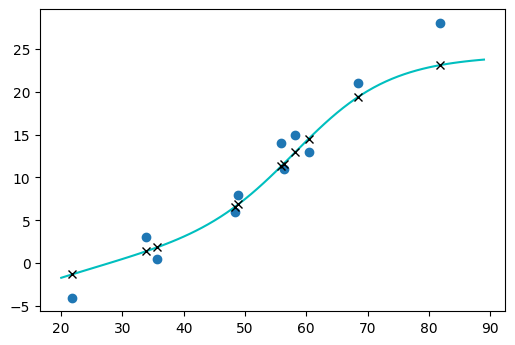

In [111]:
#線形モデルとの比較

from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)
fig = plt.figure(dpi=100)

plt.plot(t_u.numpy(), t_c.numpy(), 'o')#教師データ
plt.plot(t_range.numpy(), seq_model(0.1*t_range).detach().numpy(), 'c-')#入力は＊0.1倍してモデルを作っているから
plt.plot(t_u.numpy(), seq_model(0.1*t_u).detach().numpy(), "kx")#予測値

## 演習問題

モデルからより線形なモデルにしたい時

説明変数を増やす
隠れ層の数を増やす

In [112]:
hidden_num = 20  # 8を20に

seq_model2 = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, hidden_num)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(hidden_num, 1))
]))

seq_model,seq_model2

(Sequential(
   (hidden_Linear): Linear(in_features=1, out_features=8, bias=True)
   (hiddrn_activation): Tanh()
   (output_Linear): Linear(in_features=8, out_features=1, bias=True)
 ),
 Sequential(
   (hidden_linear): Linear(in_features=1, out_features=20, bias=True)
   (hidden_activation): Tanh()
   (output_linear): Linear(in_features=20, out_features=1, bias=True)
 ))

In [113]:
optimizer2 = optim.SGD(seq_model2.parameters(), lr=1e-3)

training_loop(n_epochs = 5000,
              optimizer = optimizer2,
              model = seq_model2,
              loss_fn = nn.MSELoss(),
              t_u_train = t_un_train,
              t_u_val = t_un_val,
              t_c_train = t_c_train,
              t_c_val = t_c_val)

Epoch 1, Training loss 148.9567, Validation loss 412.1710
Epoch 1000, Training loss 5.7512, Validation loss 45.0255
Epoch 2000, Training loss 3.1225, Validation loss 15.0001
Epoch 3000, Training loss 2.7345, Validation loss 8.4937
Epoch 4000, Training loss 2.5178, Validation loss 5.4694
Epoch 5000, Training loss 2.3745, Validation loss 3.8809


In [114]:
print("output", seq_model2(t_un_val))
print("answer", t_c_val)
print("hidden", seq_model2.hidden_linear.weight.grad.shape)

output tensor([[25.3469],
        [-3.1511]], grad_fn=<AddmmBackward0>)
answer tensor([[28.],
        [-4.]])
hidden torch.Size([20, 1])


In [115]:
seq_model2 (0.1*t_range)

tensor([[-3.7195],
        [-3.4039],
        [-3.0878],
        [-2.7702],
        [-2.4505],
        [-2.1279],
        [-1.8018],
        [-1.4715],
        [-1.1363],
        [-0.7955],
        [-0.4486],
        [-0.0948],
        [ 0.2664],
        [ 0.6357],
        [ 1.0136],
        [ 1.4009],
        [ 1.7980],
        [ 2.2055],
        [ 2.6239],
        [ 3.0538],
        [ 3.4957],
        [ 3.9498],
        [ 4.4167],
        [ 4.8965],
        [ 5.3894],
        [ 5.8956],
        [ 6.4150],
        [ 6.9475],
        [ 7.4929],
        [ 8.0508],
        [ 8.6205],
        [ 9.2015],
        [ 9.7927],
        [10.3933],
        [11.0020],
        [11.6175],
        [12.2384],
        [12.8629],
        [13.4896],
        [14.1165],
        [14.7418],
        [15.3638],
        [15.9807],
        [16.5906],
        [17.1917],
        [17.7826],
        [18.3617],
        [18.9275],
        [19.4790],
        [20.0150],
        [20.5346],
        [21.0371],
        [21.

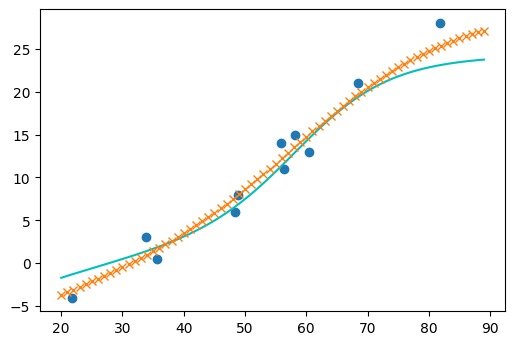

In [117]:
# 元のモデルとの比較
#　隠れそうを増やし線形にフィットした

from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)
fig = plt.figure(dpi=100)

plt.plot(t_u.numpy(), t_c.numpy(), 'o')#教師データ
plt.plot(t_range.numpy(), seq_model (0.1*t_range).detach().numpy(), 'c-')
plt.plot(t_range.numpy(), seq_model2 (0.1*t_range).detach().numpy(), 'x')#入力は＊0.1倍してモデルを作っているから

ワインデータで検討

In [129]:
# データセットの読み込み
import csv


wine_path = "../deep-learning-with-pytorch-ja-main/data/p1ch4/tabular-wine/winequality-white.csv"
#practice-for-pytorch/deep-learning-with-pytorch-ja-main/data
wineq_numpy = np.loadtxt(wine_path, dtype=np.float32, delimiter=";",
                         skiprows=1)
wineq_numpy,wineq_numpy.shape

(array([[ 7.  ,  0.27,  0.36, ...,  0.45,  8.8 ,  6.  ],
        [ 6.3 ,  0.3 ,  0.34, ...,  0.49,  9.5 ,  6.  ],
        [ 8.1 ,  0.28,  0.4 , ...,  0.44, 10.1 ,  6.  ],
        ...,
        [ 6.5 ,  0.24,  0.19, ...,  0.46,  9.4 ,  6.  ],
        [ 5.5 ,  0.29,  0.3 , ...,  0.38, 12.8 ,  7.  ],
        [ 6.  ,  0.21,  0.38, ...,  0.32, 11.8 ,  6.  ]], dtype=float32),
 (4898, 12))

In [127]:
wineq = torch.from_numpy(wineq_numpy)

In [133]:
data = wineq[:, :-1]
target_data = wineq[:, -1]
data.shape, target_data.shape

(torch.Size([4898, 11]), torch.Size([4898]))

In [135]:
n_samples=data.shape[0]
n_val = int(0.2 * n_samples)
shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

len(train_indices), len(val_indices)


(3919, 979)

In [137]:
train_indices

tensor([1871, 4038, 3781,  ..., 2450, 2009, 3486])

In [143]:
data_train = data[train_indices]
target_train = target_data[train_indices].unsqueeze(1)

In [144]:
data_val = data[val_indices]
target_val = target_data[val_indices].unsqueeze(1) 

In [145]:
data_train.shape

torch.Size([3919, 11])

In [147]:
target_train.shape

torch.Size([3919, 1])

In [151]:
seq_model3 = nn.Sequential(OrderedDict([
    ("hidden", nn.Linear(11, 200)),
    ("activation", nn.Tanh()),
    ("output", nn.Linear(200, 1))
]))

seq_model3

Sequential(
  (hidden): Linear(in_features=11, out_features=200, bias=True)
  (activation): Tanh()
  (output): Linear(in_features=200, out_features=1, bias=True)
)

In [152]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
                  t_c_train, t_c_val):
  
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train) # <1>
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val) # <1>
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward() # <2>
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")
            

In [155]:
# 訓練の実施。
optimizer3 = optim.SGD(seq_model3.parameters(), lr=1e-3) 

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer3,
    model = seq_model3,
    loss_fn = nn.MSELoss(),
    t_u_train = data_train,
    t_u_val = data_val, 
    t_c_train = target_train,
    t_c_val = target_val)

Epoch 1, Training loss 0.6107, Validation loss 0.6038
Epoch 1000, Training loss 0.6072, Validation loss 0.6057
Epoch 2000, Training loss 0.6045, Validation loss 0.6049
Epoch 3000, Training loss 0.6022, Validation loss 0.6036
Epoch 4000, Training loss 0.6001, Validation loss 0.6024
Epoch 5000, Training loss 0.5975, Validation loss 0.5994


なぜ時間がかかる？
特徴量が多いため時間がかかる

In [157]:
# プロット　total sulfur dioxideでプロットしてみる
total_sulfur_data = data_train[:,6].numpy()
total_sulfur_data 

array([168., 120., 113., ..., 157.,  98.,  98.], dtype=float32)

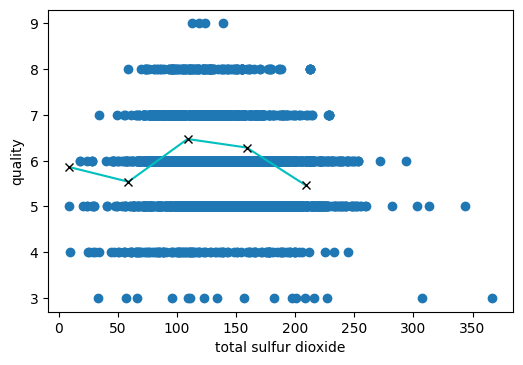

In [160]:
# x軸のレンジ
#t_range = torch.arange(total_sulfur_data.min(), total_sulfur_data.max(), step=50).unsqueeze(1)
t_range = torch.arange(total_sulfur_data.min(), 250, step=50).unsqueeze(1)


fig = plt.figure(dpi=100)
plt.xlabel("total sulfur dioxide")
plt.ylabel("quality")
plt.plot(total_sulfur_data, target_train.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model3(data_train[:t_range.shape[0],:]).detach().numpy(), 'c-')
plt.plot(t_range.numpy(), seq_model3(data_train[:t_range.shape[0],:]).detach().numpy(), 'kx')